Bias-Aware Clustering with
- KMeans
- DBSCAN
- MeanShift

And we analyse the variance of the clusters

### Init


In [3]:
# Loading the libraries
from util import *
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv(r'..\Preprocessed_datasets\preprocessed_wine.csv', index_col=0)
errors = raw_data['errors']
features = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)

### Scaling the features

In [5]:
# Scaling all attributes
to_scale = features.columns
features[to_scale] = StandardScaler().fit_transform(features[to_scale])
features[:5]

# Scaling the errors
errors_col = MinMaxScaler(feature_range = (0,1.0)).fit_transform(raw_data[['errors']])
scaling_factor = 0.8 #needs to be converted to scaling range
scaled_errors = scaling_factor * errors_col

### Utils

In [6]:
# TODO: experiment with different random states, increase number of runs
clus_model_kwargs = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}

In [55]:
def get_random_cluster(clusters):
    """This function returns the value of a random cluster
    clusters Df.Column the column clusters"""
    result = -1
    while (result == -1):
        result = clusters.iloc[random.randint(0, len(clusters.unique()))]
    return result

def plot_clusters(data):
    """This function returns a scatterplot of the clusters"""    
    scatterplot = sns.scatterplot(data=data, x="alcohol", y="ash", hue="clusters", size='errors', sizes=(100, 20), palette="tab10")
    plt.show()

def accuracy(results):
    """This function calculates the accuracy of a DF dataframe
    It requires a df.column named "errors" """ 
    if len(results) == 0:
        print("You are calculating the accuracy on a empty cluster") 
    correct = results.loc[results['errors'] == 0]
    acc = len(correct)/len(results)
    return acc

def bias_acc(data, cluster_id, cluster_col):
    """ This function calculates the negative bias, which is the accuracy of remaining clusters - accuracy of the selected cluster
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    if len(cluster_x) ==0:
        print("This is an empty cluster! cluster ", cluster_id)
    remaining_clusters = data.loc[data[cluster_col] != cluster_id]
    if len(remaining_clusters) == 0:
        print("This cluster is the entire dataset. cluster ", cluster_id)
    return accuracy(remaining_clusters) - accuracy(cluster_x)

def bias_acc_towards_global_average(data, cluster_id, cluster_col, ave_acc):
    """ This function calculates the negative bias, which is the average accuracy - accuracy of the selected cluster
    Cluster col: the name of the DF column where the cluster assignments are """
    cluster_x = data.loc[data[cluster_col] == cluster_id]
    return ave_acc - accuracy(cluster_x)

def get_next_cluster(data):
    """ This function returns the cluster number with the highest variance. The variance is calculated based on the errors of each cluster.
    The cluster with the highest variance will be selected as splitting cluster
    The function requires df.columns named "clusters" and "errors" """
    n_cluster = max(data['clusters'])
    highest_variance = -1
    cluster_number = 0

    for i in data['clusters'].unique():
        if (i == -1):
            continue
        cluster_i = data.loc[data['clusters'] == i]
        variance_cluster = np.var(cluster_i['errors'])
        
        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            cluster_number = i
            print('--> Cluster with the highest variance:', cluster_number)

    return cluster_number

def get_max_abs_bias(fulldata, function=bias_acc):
    """ This function returns the highest negative bias of the newly introduced clusters 
    fulldata (DataFrame) should include a column new_clusters """
    max_abs_bias = -999999
    for cluster_number in fulldata['new_clusters'].unique():
        if cluster_number == -1: #Outliers in DBScan
            continue
        current_bias = abs(function(fulldata, cluster_number, "new_clusters"))
        if current_bias > max_abs_bias:
            max_abs_bias = current_bias
    return max_abs_bias

def calculate_variance(data):
    """This function calculates the variance for a DF. It requires a df.column named "clusters" and it uses the bias_acc_towards_global_avg"""
    variance_list_local = []
    for j in data['clusters'].unique():
        average_accuracy = accuracy(data)
        neg_bias_clus = bias_acc_towards_global_average(data, j, 'clusters', average_accuracy)
        variance_list_local.append(neg_bias_clus) #variance_list was "neg_bias_list" before
    variance = np.var(variance_list_local) #this was "neg_bias_list"
    return variance

def initialize_dataset(raw_data, just_features=True,scale_features=True, with_classes=True):
    """Initialisation of the dataset. Scales all the features and can also scale the errors, which can be included or excluded for clustering 
    It returns a scaled dataset with new columns "clusters" = 0 and "new_clusters" = -1, which are required for HBAC """
    new_data = raw_data.copy(deep=True)
    if just_features:
        new_data = new_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
    
    if scale_features:
        to_scale = raw_data.drop(['predicted_class', 'true_class', 'errors'], axis=1).columns
        new_data[to_scale] = StandardScaler().fit_transform(features[to_scale])
    
    if with_classes:
        for col in ['predicted_class', 'true_class', 'errors']:
            new_data[col] = raw_data[col]

    new_data['clusters'] = 0
    new_data['new_clusters'] = -1
    return new_data

def get_min_cluster_size(data):
    """Returns the size of the smallest new cluster"""
    min_cluster_size = len(data)
    for i in data['new_clusters'].unique():
        # exclude the cluster -1 from being seen as a cluster, since it contains outliers
        if i == -1:
            continue
        size = len(full_data.loc[full_data['new_clusters']==i])
        if size < min_cluster_size:
            min_cluster_size = size
    return min_cluster_size

## 1. KMeans Clustering without errors as feature 

In [56]:
# Combine scaled features w. class & error labels
full_data = initialize_dataset(raw_data)
full_data.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,predicted_class,true_class,errors,clusters,new_clusters
12,0.687846,-0.160373,0.141557,-0.694417,-0.834587,0.004312,0.267992,-0.318793,0.017405,0.697247,0.405843,-0.146241,1.256507,0,0.0,0.0,0,-1
23,-0.356751,-0.343481,0.502356,-0.101678,-0.381526,-0.222556,-0.278564,-0.635733,-0.650337,-0.367414,-0.033392,1.394286,0.408775,1,0.0,1.0,0,-1
25,-0.124619,0.290352,2.798346,2.269277,1.808272,0.061029,0.155878,1.582845,0.227267,-0.590546,0.259431,0.486852,-0.105424,0,0.0,0.0,0,-1
35,0.374467,-0.047692,0.141557,0.787430,-0.003974,0.193369,0.576306,-0.635733,0.112797,0.378486,-0.399421,1.056636,0.144727,1,0.0,1.0,0,-1
13,1.848509,-0.160373,0.075958,-2.209194,-0.683567,0.949596,1.571320,1.160258,1.925240,0.569743,1.137900,-0.504994,0.784001,2,0.0,1.0,0,-1


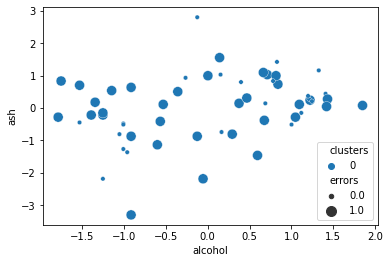

average_accuracy is:  0.40350877192982454


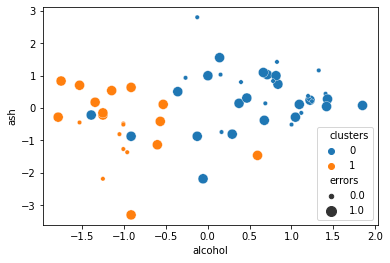

--> Cluster with the highest variance: 0


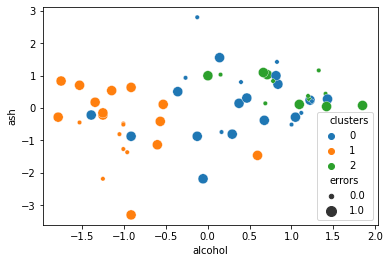

--> Cluster with the highest variance: 2


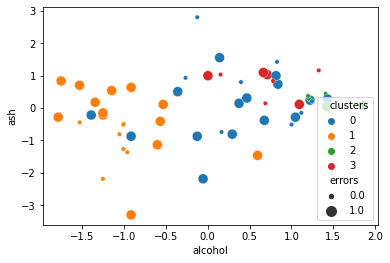

--> Cluster with the highest variance: 3


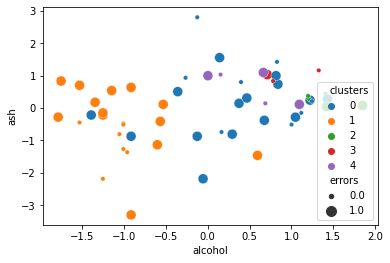

--> Cluster with the highest variance: 4
MAX_ITER
[0.0003188775510204089, 0.006916484602629585, 0.01000000803724136, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943, 0.016584133842572943]


In [57]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 8
minimal_acceptable_cluster_size = 1
print("average_accuracy is: ", average_accuracy) 

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply Kmeans 
    kmeans_algo = KMeans(**clus_model_kwargs).fit(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1))
    
    candidate_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class',                                                                                                               'errors'], axis=1)),index=candidate_cluster.index) 
    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_abs_bias(full_data)
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias >= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

### 1. Analysing the clustering results


<AxesSubplot:ylabel='variance excl errors'>

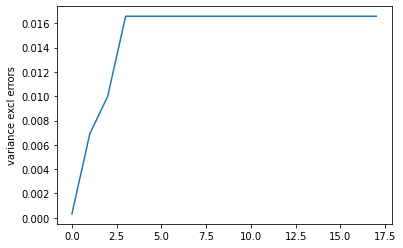

In [59]:
variance_df_kmeans = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df_kmeans, x=variance_df_kmeans.index,y="variance excl errors")

## 2. Bias-Aware DBSCAN

In [60]:
from sklearn.cluster import DBSCAN

In [102]:
# Combine scaled features w. class & error labels
full_data = initialize_dataset(raw_data)

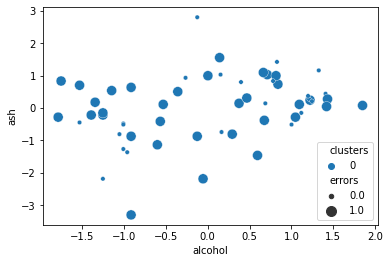

12     0
23     1
25    -1
35    -1
13    -1
65    -1
48    -1
78    -1
3     -1
6      2
42    -1
2     -1
29     2
45    -1
106   -1
94    -1
5     -1
53    -1
93    -1
41    -1
54    -1
24     1
64    -1
28    -1
89    -1
92    -1
79    -1
14    -1
44    -1
66    -1
85    -1
99    -1
57    -1
71    -1
11     0
36    -1
62    -1
0      3
27    -1
98    -1
20     3
77    -1
30    -1
17     4
59    -1
21    -1
55    -1
16     4
91    -1
100   -1
74    -1
87    -1
90    -1
84    -1
18    -1
97    -1
61    -1
Name: new_clusters, dtype: int32


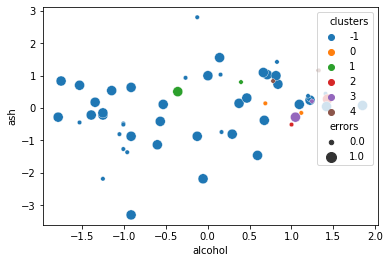

--> Cluster with the highest variance: 0
--> Cluster with the highest variance: 1
MAX_ITER
[0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101, 0.06795747195815101]


In [103]:
MAX_ITER = 20
epsilon = 1.5
minimum_samples = 2
x = 0 # cluster number
initial_bias = 0
plot_clusters(full_data)
variance_list = []
minimal_splittable_cluster_size = 5
minimal_acceptable_cluster_size = 1
average_accuracy = accuracy(full_data)

for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply DBSCAN
    candidate_cluster['new_clusters'] = pd.DataFrame(DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class', 'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_abs_bias(full_data)
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias >= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        print(full_data['new_clusters'])
        
        first = True
        dif = 1
        for clstr in full_data['new_clusters'].unique():
            if (clstr == -1):
                full_data['clusters'][full_data['new_clusters'] == clstr] = -1
            elif first:
                full_data['clusters'][full_data['new_clusters'] == clstr] = x
                first = False
            else:
                full_data['clusters'][full_data['new_clusters'] == clstr] =  n_cluster + dif
                dif += 1
            
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 2. DBSCAN Results

<AxesSubplot:ylabel='variance excl errors'>

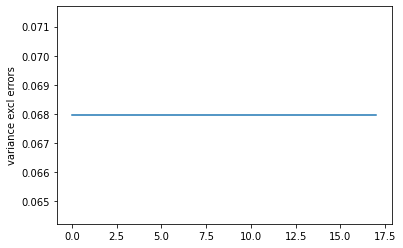

In [104]:
variance_df_dbscan = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df_dbscan, x=variance_df_dbscan.index,y="variance excl errors")

## 3. Bias-Aware Mean Shift 


The estimate_bandwidth function to estimate the bandwidth parameter of Mean Shift is significantly better than manually selecting a bandwidth value.

In [76]:
from sklearn.cluster import MeanShift, estimate_bandwidth 
full_data = initialize_dataset(raw_data)

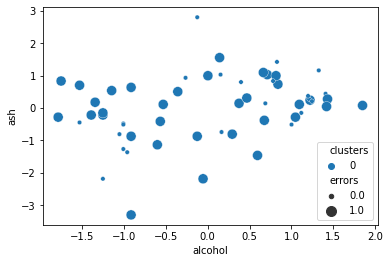

average_accuracy is:  0.40350877192982454


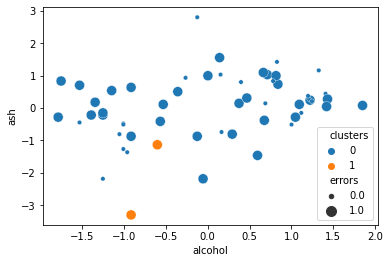

--> Cluster with the highest variance: 0


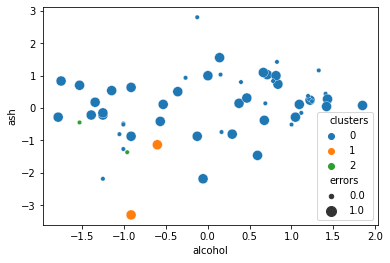

--> Cluster with the highest variance: 0
MAX_ITER
[0.0437190082644628, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717, 0.1690597682053717]


In [77]:
MAX_ITER = 20
x = 0 # cluster number
initial_bias = 0
bw1 = estimate_bandwidth(initialize_dataset(raw_data, just_features=True, scale_features=True, with_classes=False))
plot_clusters(full_data)
variance_list = []
average_accuracy = accuracy(full_data) 
minimal_splittable_cluster_size = 5
minimal_acceptable_cluster_size = 1
print("average_accuracy is: ", average_accuracy) 


for i in range(1, MAX_ITER):
    if i != 1:
        variance_list.append(calculate_variance(full_data)) 
    full_data['new_clusters'] = -1
    candidate_cluster = full_data.loc[full_data['clusters'] == x] 

    if len(candidate_cluster) < minimal_splittable_cluster_size:
        x = get_random_cluster(full_data['clusters'])
        continue
    
    # Apply MeanShift
    candidate_cluster['new_clusters'] = pd.DataFrame(MeanShift(bandwidth=bw1).fit_predict(candidate_cluster.drop(['clusters', 'new_clusters', 'predicted_class',                                                    'true_class', 'errors'], axis=1)), index=candidate_cluster.index)

    full_data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(full_data['new_clusters'])

    max_abs_bias = get_max_abs_bias(full_data)
    min_new_size = get_min_cluster_size(full_data)
    
    if (max_abs_bias >= initial_bias) & (min_new_size > minimal_acceptable_cluster_size): 
        # Add new cluster
        n_cluster = max(full_data['clusters'])
        full_data['clusters'][full_data['new_clusters'] == 1] =  n_cluster + 1
        
        plot_clusters(full_data)
        x = get_next_cluster(full_data)
        initial_bias = max_abs_bias
    else:
        x = get_random_cluster(full_data['clusters'])
        
print('MAX_ITER')

print(variance_list)

## 3. Mean-Shift Results

<AxesSubplot:ylabel='variance excl errors'>

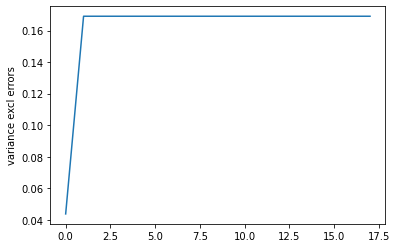

In [78]:
variance_df = pd.DataFrame(variance_list).rename(columns={0:"variance excl errors"})
sns.lineplot(data=variance_df, x=variance_df.index,y="variance excl errors")

## Old version Mean Shift (with Variance Clusters error)

# Baselines: Clustering without recursivity

## DBSCAN without recursivity

In [ ]:
var_list = []
epsilon = 3
minimum_samples = 2
features_i = features.copy(deep=True)
features_i["errors"] = errors

for n in range(2, 58):
    model = DBSCAN(eps=epsilon, min_samples=minimum_samples).fit_predict(features_i)
    features_i['cluster_results'] = pd.DataFrame(model, index=features_i.index)

    neg_bias_list = []
    epsilon = epsilon-0.1
    if  len(features_i["cluster_results"].unique()) == 1:
        print("One cluster left on iteration ", n)
        print("With epsilon", epsilon)
        break
    for i in features_i["cluster_results"].unique():
        print(features_i["cluster_results"].unique())
        #print('features_i', features_i)
        neg_bias_list.append(bias_acc(features_i, i,"cluster_results"))
    var_list.append(np.var(neg_bias_list))
print(var_list)

plt.plot(var_list)

In [18]:
# exporting the biased cluster dataframe for further analysis
import os
path = r'..\\Clustered_datasets\\'
# full_data.to_csv(os.path.join(path, r'biased_wine_clusters.csv'))
